In [8]:
%load_ext autoreload
%autoreload 2
from experiment.proj1_helpers import *
from implementations import * 
from experiment.cleaning import *
from experiment.cross_validation import *
from experiment.simulation import *
from experiment.visualisation import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
data_path = "data/train.csv"

In [10]:
y, x, ids = load_csv_data(data_path, sub_sample=False)

## Exploratory Data Analysis

All features are numeric. The number of jets is discrete.

#### Distribution of the features
Let's look at the distribution of some of the features.

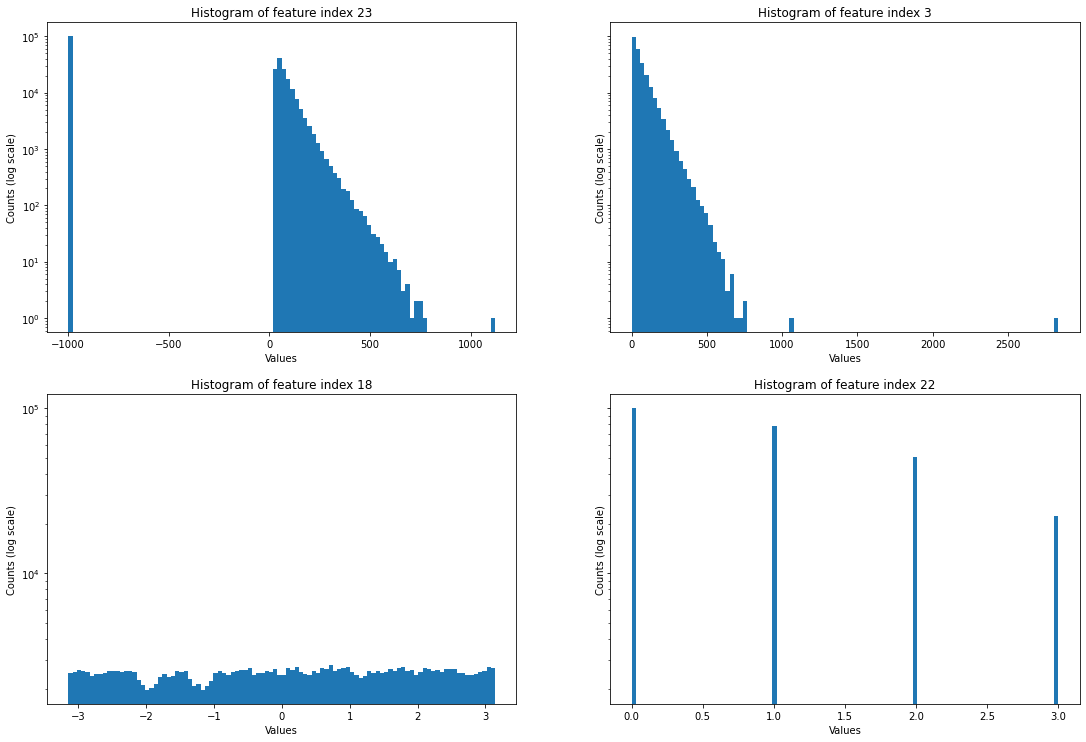

In [11]:
quad_histograms(x,23,3,18,22)

We can see that some features clearly have default values to -999, some seem to have extreme outliers (e.g. feature 3). We can also check that feature index 22 only has non negative integer values.

### Data cleaning

In [12]:
# Check if the values for the number of jets are non negative integers
# Column 22 corresponds to this variable
print(f'Number of negative values : {np.sum(x[:, 22] < 0)}')

Number of negative values : 0


In [13]:
# Check that no value in the table is a nan value
np.sum(x==np.nan)

0

We can see that we have 250'000 data points with 30 features each.

In [14]:
x.shape

(250000, 30)

In [15]:
np.sum(x == -999, axis=0)

array([ 38114,      0,      0,      0, 177457, 177457, 177457,      0,
            0,      0,      0,      0, 177457,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,  99913,
        99913,  99913, 177457, 177457, 177457,      0])

We can see that some of the features have a very high number of undefined values (-999). We could replace this undefined values by e.g. 0 or the mean of the remaining values but this would result in columns having its majority of entries (e.g. 177'000 / 250'000 $\approx$ 0.7) at the same value. This would imply that there is not a lot of variance in the feature and therefore this does not give much information about the label we want to predict. So we decided to drop the features where more than half of the rows are at -999.

In [16]:
# We remove the features where more than half of the rows are -999
x_cleaned, col_removed_training = remove_col_default_values(x)

In [17]:
col_removed_training

[4, 5, 6, 12, 26, 27, 28]

We can see that with this method we dropped 7 columns.

We also looked if some rows were having more than half of its features set to a default value (i.e. -999). In this case, there were no such rows.

In [24]:
check_nb_rows_default_features(x_cleaned)

Number of rows : 0




For the remaining default values, we decided to set them to -999. We did this instead of e.g. replacing them by the mean or median of the remaining values because we noted that the models actually performed better.

In [26]:
x_cleaned, default_values_training = replace_by_default_value(x_cleaned)

Some features represents angles, which are supposed to be in the range $[\pi; -\pi[$ according to the documentation of the dataset (https://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf). Let's check this is the case.

In [28]:
cols_angle = [11, 14, 16, 21]
x_cleaned = check_all_azimuth_angles(x_cleaned, cols_angle)

Number of values outside [-pi;pi[ (col 11): 0
Number of values outside [-pi;pi[ (col 14): 0
Number of values outside [-pi;pi[ (col 16): 0
Number of values outside [-pi;pi[ (col 21): 0


We can see that some of the features have rows with azimuth outside the range. For these features indexes we deciced to put the non-valid values back in the $[-\pi; \pi[$ interval by taking the modulo $2 \pi$ and subtracting $\pi$.

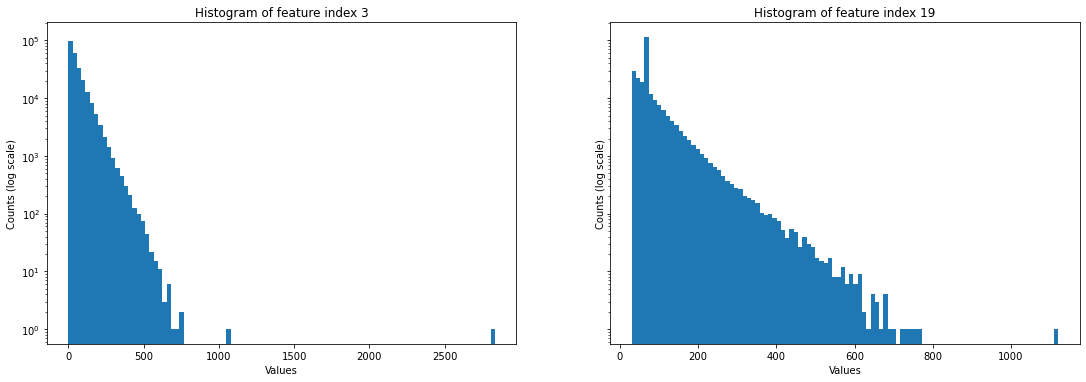

In [29]:
double_histograms(x_cleaned, 3,19)

#### Removing outliers
We can observe that in some features there still seems to be some outliers (e.g. see the histogram above for feature index 3).


We will deal with them using a method based on the Inter Quartile Range (IQR). 

In [30]:
x_cleaned, above_lim_training, below_lim_training = clip_IQR(x_cleaned)

In [31]:
cols_angle

[11, 14, 16, 21]

In [32]:
x_cleaned_copy = x_cleaned.copy()

End of processing + expansion
Beginning training
Beginning cross-validation
Perform cross-validation for lambda=0.0000 and degree=2
Loss for lambda=0.0000 and degree=2 : tr=0.740069, te=0.742243

Perform cross-validation for lambda=0.0000 and degree=2
Loss for lambda=0.0000 and degree=2 : tr=0.740069, te=0.742243

Perform cross-validation for lambda=0.0000 and degree=2
Loss for lambda=0.0000 and degree=2 : tr=0.740069, te=0.742243

Perform cross-validation for lambda=0.0000 and degree=2
Loss for lambda=0.0000 and degree=2 : tr=0.740069, te=0.742243

Perform cross-validation for lambda=0.0000 and degree=2
Loss for lambda=0.0000 and degree=2 : tr=0.740069, te=0.742243

Perform cross-validation for lambda=0.0000 and degree=2
Loss for lambda=0.0000 and degree=2 : tr=0.740069, te=0.742243

Perform cross-validation for lambda=0.0000 and degree=2
Loss for lambda=0.0000 and degree=2 : tr=0.740069, te=0.742240

Perform cross-validation for lambda=0.0000 and degree=2
Loss for lambda=0.0000 and d

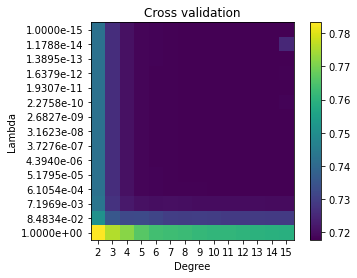

Accuracy of ridge_regression on the local test set : 0.8262
F1-score of ridge_regression on the local test set : 0.7369


In [58]:
acc_local_test, f1_local_test, w_best, best_degree, best_lambda = run_experiment(y, x_cleaned_copy, 'ridge_regression', 1, 0.8, cols_angle, max_degree=15)

In [61]:
best_degree, best_lambda

(10, 4.393970560760786e-06)

In [62]:
w_best.shape

(704,)

In [25]:
x_cleaned_copy.shape

(250000, 23)

End of processing + expansion
Beginning training
Beginning cross-validation
Perform cross-validation for lambda=0.0000 and degree=10
Loss for lambda=0.0000 and degree=10 : tr=0.715900, te=0.718102

Perform cross-validation for lambda=0.0000 and degree=10
Loss for lambda=0.0000 and degree=10 : tr=0.715907, te=0.718099

Perform cross-validation for lambda=0.0000 and degree=10
Loss for lambda=0.0000 and degree=10 : tr=0.715908, te=0.718098

Perform cross-validation for lambda=0.0000 and degree=10
Loss for lambda=0.0000 and degree=10 : tr=0.715909, te=0.718096

Perform cross-validation for lambda=0.0000 and degree=10
Loss for lambda=0.0000 and degree=10 : tr=0.715909, te=0.718095

Perform cross-validation for lambda=0.0000 and degree=10
Loss for lambda=0.0000 and degree=10 : tr=0.715911, te=0.718094

Perform cross-validation for lambda=0.0000 and degree=10
Loss for lambda=0.0000 and degree=10 : tr=0.715912, te=0.718094

Perform cross-validation for lambda=0.0000 and degree=10
Loss for lamb

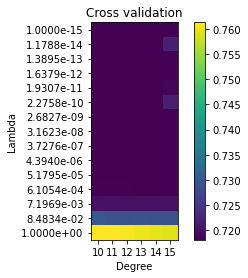

Accuracy of ridge_regression on the local test set : 0.8258
F1-score of ridge_regression on the local test set : 0.7361


In [53]:
acc_local_test, f1_local_test, w_best, best_degree, best_lambda = run_experiment(y, np.delete(x_cleaned_copy,22,axis=1), 'ridge_regression', 1, 0.8, cols_angle, max_degree=15)

In [ ]:
best_degree, best_lambda
w_best.shape

In [63]:
from run import main
main()

==> Loading and preprocessing training data...

Number of values outside [-pi;pi[ (col 11): 9
Number of values outside [-pi;pi[ (col 14): 11
Number of values outside [-pi;pi[ (col 16): 9
Number of values outside [-pi;pi[ (col 21): 3

==> Training model...

==> Loading and preprocessing test data...

Number of values outside [-pi;pi[ (col 11): 19
Number of values outside [-pi;pi[ (col 14): 17
Number of values outside [-pi;pi[ (col 16): 22
Number of values outside [-pi;pi[ (col 21): 9
(704,)

==> Predicting labels for the test set...

==> Creating submission file...

==> Submission files saved.
